In [1]:
import math
import matplotlib.pyplot as plt

# --- 1. 기본 상수 정의 ---
GAMMA_WATER = 1.0  # 물의 단위중량 (t/m^3)

# --- 2. 옹벽 단면 및 재료 특성 (3장 최종 설계안 기준) ---
# 콘크리트 특성
GAMMA_CONCRETE = 2.4  # 콘크리트 단위중량 (t/m^3)

# 옹벽 치수 (m)
H_WALL = 6.0          # 옹벽 배면 높이
B_BASE = 3.0          # 기초 저판 전체 폭
THICK_BASE = 1.0      # 기초 저판 두께
D_EMBED = 1.5         # 근입 깊이

# 스템(등변사다리꼴) 치수 (m)
H_STEM = 5.0          # 스템 높이
W_STEM_TOP = 0.9      # 스템 상단 폭
W_STEM_BOTTOM = 1.8   # 스템 하단 폭

# --- 3. 지반 특성 (2장 설계 조건 기준) ---
# 뒤채움흙 (매립토층)
GAMMA_SOIL_BACKFILL = 1.85  # 단위중량 (t/m^3)
PHI_SOIL_BACKFILL = 30      # 내부마찰각 (도)
Ka = 1/3                    # 주동토압계수

# 기초지반 (풍화토층)
GAMMA_SOIL_FOUNDATION = 1.9 # 단위중량 (t/m^3)
PHI_SOIL_FOUNDATION = 32    # 내부마찰각 (도)
C_SOIL_FOUNDATION = 0.5     # 점착력 (t/m^2)
Kp = 3.25                   # 수동토압계수

# --- 4. 변하지 않는 저항력/모멘트 값 (3장 계산 결과) ---
# 안정성 검토에 사용될 고정 값들
TOTAL_VERTICAL_LOAD = 31.03 # 전체 수직하중 (t/m)
RESISTING_MOMENT = 54.9     # 저항모멘트 (t*m)
# 보수적 기준(k1,k2=2/3)을 적용한 활동 저항력 요소들
F_friction_base = 12.1      # 마찰 저항력 (t/m)
F_cohesion_base = 1.0       # 점착 저항력 (t/m)

print("기본 변수 설정이 완료되었습니다.")

기본 변수 설정이 완료되었습니다.


In [2]:
# --- 1단계 코드 (이전 단계에서 작성) ---
import math
import matplotlib.pyplot as plt

# ... (이전 코드 내용) ...
# 보수적 기준(k1,k2=2/3)을 적용한 최종 활동 저항력
Pp_final = (0.5 * GAMMA_SOIL_FOUNDATION * D_EMBED**2 * Kp) + (2 * C_SOIL_FOUNDATION * math.sqrt(Kp) * D_EMBED)
FR_TOTAL = F_friction_base + F_cohesion_base + Pp_final
# ------------------------------------


# --- 2단계: 안정성 계산 함수 정의 ---
def calculate_stability(hw):
    """
    주어진 지하수위(hw)에 대한 전도 및 활동 안전율을 계산하는 함수
    hw: 기초 저판 바닥에서부터의 지하수위 높이 (m)
    """
    
    # 이 함수 안에서는 hw가 0보다 클 때만 계산
    if hw <= 0:
        # 지하수위가 없으면 3장에서 계산한 초기 안전율을 반환
        fs_overturning_initial = 2.47
        fs_sliding_initial = 2.05
        return fs_overturning_initial, fs_sliding_initial

    # --- 가. 수압(Pw) 및 수압에 의한 전도모멘트(Mw) 계산 ---
    Pw = 0.5 * GAMMA_WATER * hw**2
    Mw = Pw * (hw / 3.0)
    
    # --- 나. 변경된 주동토압(Pa') 및 모멘트(Ma') 계산 ---
    h_dry = H_WALL - hw # 물에 잠기지 않은 흙의 높이

    # 1. 물에 잠기지 않은 흙으로 인한 토압/모멘트
    Pa_dry = 0.5 * Ka * GAMMA_SOIL_BACKFILL * h_dry**2
    Ma_dry = Pa_dry * (hw + h_dry / 3.0)
    
    # 2. 물에 잠긴 흙으로 인한 토압/모멘트
    gamma_sub = GAMMA_SOIL_BACKFILL - GAMMA_WATER # 수중 단위중량
    
    # 압력 계산
    sigma_top = Ka * GAMMA_SOIL_BACKFILL * h_dry # 수위 지점에서의 토압
    sigma_bottom_increase = Ka * gamma_sub * hw # 수위 아래에서의 토압 증가량
    
    # 토압을 사각형과 삼각형으로 분리하여 계산
    Pa_wet_rect = sigma_top * hw
    Pa_wet_tri = 0.5 * sigma_bottom_increase * hw
    
    # 모멘트 계산
    Ma_wet_rect = Pa_wet_rect * (hw / 2.0)
    Ma_wet_tri = Pa_wet_tri * (hw / 3.0)
    
    # --- 다. 새로운 전체 공격력 계산 ---
    Pa_new = Pa_dry + Pa_wet_rect + Pa_wet_tri # 전체 주동토압
    Fd_new = Pa_new + Pw # 전체 수평활동력
    
    Ma_new = Ma_dry + Ma_wet_rect + Ma_wet_tri # 전체 주동토압 모멘트
    Mo_new = Ma_new + Mw # 전체 전도모멘트

    # --- 라. 새로운 안전율 계산 ---
    fs_overturning = RESISTING_MOMENT / Mo_new
    fs_sliding = FR_TOTAL / Fd_new
    
    return fs_overturning, fs_sliding

# --- 테스트 실행 ---
# 지하수위가 1.0m 상승했을 때의 안전율 계산 및 출력
fs_o_test, fs_s_test = calculate_stability(1.0)
print(f"지하수위 1.0m 상승 시:")
print(f"  - 전도 안전율: {fs_o_test:.2f}")
print(f"  - 활동 안전율: {fs_s_test:.2f}")

지하수위 1.0m 상승 시:
  - 전도 안전율: 2.46
  - 활동 안전율: 1.99


지하수위 0.0m 상승 시: 전도 F.S.=2.47, 활동 F.S.=2.05
지하수위 1.0m 상승 시: 전도 F.S.=2.46, 활동 F.S.=1.99
지하수위 2.0m 상승 시: 전도 F.S.=2.38, 활동 F.S.=1.83
지하수위 3.0m 상승 시: 전도 F.S.=2.18, 활동 F.S.=1.61
지하수위 4.0m 상승 시: 전도 F.S.=1.87, 활동 F.S.=1.38
지하수위 5.0m 상승 시: 전도 F.S.=1.52, 활동 F.S.=1.17
지하수위 6.0m 상승 시: 전도 F.S.=1.19, 활동 F.S.=0.98


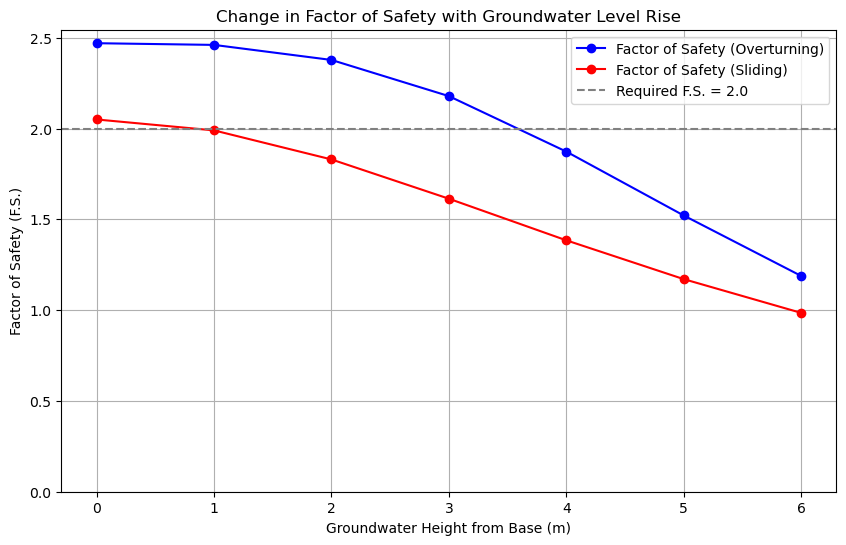

In [3]:
# --- 3단계: 반복 계산 및 그래프 생성 ---

# 결과를 저장할 빈 리스트 생성
hw_list = []
fs_overturning_list = []
fs_sliding_list = []

# 지하수위를 0m부터 6m까지 1m 단위로 변화시키며 반복 계산
for hw in range(7):  # 0, 1, 2, 3, 4, 5, 6
    # 이전에 만든 함수를 호출하여 해당 수위의 안전율 계산
    fs_o, fs_s = calculate_stability(float(hw))
    
    # 결과를 각 리스트에 추가
    hw_list.append(hw)
    fs_overturning_list.append(fs_o)
    fs_sliding_list.append(fs_s)
    
    # 각 단계별 결과 출력
    print(f"지하수위 {hw:.1f}m 상승 시: 전도 F.S.={fs_o:.2f}, 활동 F.S.={fs_s:.2f}")

# --- 그래프 그리기 ---
plt.figure(figsize=(10, 6)) # 그래프 크기 설정

# 전도/활동 안전율 그래프 그리기
plt.plot(hw_list, fs_overturning_list, 'bo-', label='Factor of Safety (Overturning)')
plt.plot(hw_list, fs_sliding_list, 'ro-', label='Factor of Safety (Sliding)')

# 기준 안전율선 그리기
plt.axhline(y=2.0, color='gray', linestyle='--', label='Required F.S. = 2.0')

# 그래프 제목 및 축 레이블 설정 (한글 폰트가 필요할 수 있습니다)
plt.title('Change in Factor of Safety with Groundwater Level Rise')
plt.xlabel('Groundwater Height from Base (m)')
plt.ylabel('Factor of Safety (F.S.)')
plt.grid(True) # 그리드 표시
plt.legend() # 범례 표시
plt.ylim(bottom=0) # Y축 시작을 0으로 설정

# 그래프 보여주기
plt.show()